In [34]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import gurobipy as gp
from gurobipy import GRB

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.decomposition import KernelPCA

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import svm

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, matthews_corrcoef, balanced_accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, auc
from sklearn.inspection import DecisionBoundaryDisplay

# Step 01: Data Sampling

In [2]:
# Function to generate samples for loads and wind production, using baseload daily profiles and adding variability
wind_profile = [1.2, 1.2, 1.2, 1.2, 1.1, 1.1, 1.1, 1.0, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 1.0, 1.1, 1.1, 1.1, 1.2, 1.2, 1.2, 1.2]
load_profile = [13, 12.5, 12, 12, 12, 12.5, 14, 15.5, 16.5, 16.5, 17, 17, 17, 16.5, 16.5, 16.5, 16.5, 17.5, 19, 19, 18.5, 17.5, 15.5, 14]
# Normalize daily load profile
load_profile = np.array(load_profile) / max(load_profile) + 0.2

# Function to generate samples for loads and wind production
def generate_samples(
    daily_load_baseload_profile, daily_wind_baseload_profile,num_samples, loads_mean, wind_mean, sd_daily=0.1, sd_hourly=0.05, sd_L=0.1, sd_W=0.2, wind_shape=1.75):

    data = []
    for sample_num in range(1, num_samples + 1):
        # Daily variability for all features
        daily_var = np.random.normal(0, sd_daily)
        hourly_var2 = np.random.weibull(wind_shape) * 0.40 # Wind variability

        for hour in range(24):
            # Hourly variability
            hourly_var = np.random.normal(0, sd_hourly)
            weibull_var = np.random.weibull(wind_shape) * 0.35 # Wind variability

            # Generate loads using normal distribution
            load_sample = [
                round(
                    np.clip(
                        np.random.normal(
                            mean * daily_load_baseload_profile[hour] * (1 + daily_var) * (1 + hourly_var), mean * sd_L), 0, mean * 2), 2)
                for mean in loads_mean
            ]

            # Generate wind using Weibull distribution
            wind_sample = [
                round(np.clip(np.random.normal(daily_wind_baseload_profile[hour] * hourly_var2, sd_W),0 + hourly_var**2, 1-hourly_var**2) * mean, 2)
                for mean in wind_mean
            ]


            # Combine into a single row
            row = [sample_num, hour] + load_sample + wind_sample
            data.append(row)
    return data

In [3]:

# Define parameters
loads_mean = [10, 80, 70]  # Mean loads for L1, L2, L3
wind_mean = [10, 30]  # Mean wind capacities for W1, W2

# Call the function
samples_data = generate_samples(load_profile, wind_profile, num_samples=1000, loads_mean=loads_mean, wind_mean=wind_mean)

# Define column names
columns = ["Sample_Nr", "Hour", "L1", "L2", "L3", "W1", "W2"]

# Convert to DataFrame
samples_df = pd.DataFrame(samples_data, columns=columns)

In [4]:
corr_matrix = pd.DataFrame(samples_df).corr()
corr_matrix.style.background_gradient(cmap="coolwarm", axis=None)

,Sample_Nr,Hour,L1,L2,L3,W1,W2
Sample_Nr,1.000000,0.000000,0.012937,0.006268,0.007193,0.007984,0.006702
Hour,0.000000,1.000000,0.435811,0.436759,0.439673,0.004875,0.001327
L1,0.012937,0.435811,1.000000,0.728958,0.728680,-0.040001,-0.044231
L2,0.006268,0.436759,0.728958,1.000000,0.729163,-0.039904,-0.040985
L3,0.007193,0.439673,0.728680,0.729163,1.000000,-0.041037,-0.043345
W1,0.007984,0.004875,-0.040001,-0.039904,-0.041037,1.000000,0.550986
W2,0.006702,0.001327,-0.044231,-0.040985,-0.043345,0.550986,1.000000


# Step 02: Optimisation Model

In [5]:
# Load the data from the data folder
wind_forecast = samples_df[['Hour', 'W1', 'W2']].copy()
load = samples_df[['Hour', 'L1', 'L2','L3']].copy()
bus = pd.read_csv('Data/B (power transfer factor of each bus to each line).csv', delimiter=';')
max_prod = pd.read_csv('Data/Maximum production of generating units.csv', delimiter=';')
min_prod = pd.read_csv('Data/Minimum production of generating units.csv', delimiter=';')
min_down_time = pd.read_csv('Data/Minimum down time of generating units.csv', delimiter=';')
min_up_time = pd.read_csv('Data/Minimum up time of generating units.csv', delimiter=';')
prod_cost = pd.read_csv('Data/Production cost of generating units.csv', delimiter=';')
ramp_rate = pd.read_csv('Data/Ramping rate of generating units.csv', delimiter=';')
start_up_cost = pd.read_csv('Data/Start-up cost of generating units.csv', delimiter=';')
transmission_cap = pd.read_csv('Data/Transmission capacity of lines.csv', delimiter=';')


In [6]:
Nodes = ['Node 1', 'Node 2', 'Node 3', 'Node 4', 'Node 5', 'Node 6']
Generator = ['G1', 'G2', 'G3']
Generator_node = {'Node 1': 'G1', 'Node 2': 'G2', 'Node 6': 'G3'}
Load = ['L1', 'L2', 'L3']
Load_node = {'Node 4': 'L1', 'Node 5': 'L2', 'Node 6': 'L3'}
Wind = ['W1', 'W2']
Wind_node = {'Node 4': 'W1', 'Node 5': 'W2'}
Transmission = ['Line 1', 'Line 2', 'Line 3', 'Line 4', 'Line 5', 'Line 6','Line 7']
Transmission_node = {'Line 1': ['Node 1', 'Node 2'], 'Line 2': ['Node 2', 'Node 3'], 'Line 3': ['Node 3', 'Node 6'], 'Line 4': ['Node 5', 'Node 6'], 'Line 5': ['Node 4', 'Node 5'], 'Line 6': ['Node 2', 'Node 4'],'Line 6': ['Node 1', 'Node 4']}    

In [7]:
# Create matrix with the nodes as columns and the generators, loads and winds as rows, with 1 if connected to the node
Gen_n = np.zeros((len(Generator), len(Nodes)))
Load_n = np.zeros((len(Load), len(Nodes)))
Wind_n = np.zeros((len(Wind), len(Nodes)))
Transmission_n = np.zeros((len(Transmission), len(Nodes)))

# Populate the matrix
for i, g in enumerate(Generator):  # Iterate over generators
    for j, node in enumerate(Nodes):  # Iterate over nodes
        if Generator_node.get(node) == g:  # Check if generator is connected to the node
            Gen_n[i, j] = 1

for i, l in enumerate(Load):  # Iterate over loads
    for j, node in enumerate(Nodes):  # Iterate over nodes
        if Load_node.get(node) == l:  # Check if load is connected to the node
            Load_n[i, j] = 1

for i, w in enumerate(Wind):  # Iterate over winds
    for j, node in enumerate(Nodes):  # Iterate over nodes
        if Wind_node.get(node) == w:  # Check if wind is connected to the node
            Wind_n[i, j] = 1

for i, t in enumerate(Transmission):  # Iterate over transmission lines
    connected_nodes = Transmission_node.get(t, [])  # Get nodes connected by the transmission line
    for node in connected_nodes:  # For each node connected by the transmission line
        if node in Nodes:  # Ensure the node is valid (exists in Nodes list)
            j = Nodes.index(node)  # Get the column index for the node in Transmission_n
            Transmission_n[i, j] = 1  # Set the corresponding element to 1
            


In [8]:
# Define the input data class
class InputData:
    
    def __init__(
        self,
        wind_forecast: pd.DataFrame, 
        bus: pd.DataFrame,
        load: pd.DataFrame,
        max_prod: pd.DataFrame,
        min_prod: pd.DataFrame,
        min_down_time: pd.DataFrame,
        min_up_time: pd.DataFrame,
        prod_cost: pd.DataFrame,
        ramp_rate: pd.DataFrame,
        start_up_cost: pd.DataFrame,
        transmission_cap: pd.DataFrame
    ):
        self.time = range(len(wind_forecast))  #maybe define it with lenght of wind_production
        self.wind_forecast = wind_forecast
        self.bus = bus
        self.load = load
        self.max_prod = max_prod
        self.min_prod = min_prod
        self.min_down_time = min_down_time
        self.min_up_time = min_up_time
        self.prod_cost = prod_cost
        self.ramp_rate = ramp_rate
        self.start_up_cost = start_up_cost
        self.transmission_cap = transmission_cap
        self.M = 1000000  # Penalty for having flexible demand
        self.Gen_n = Gen_n  # Matrix mapping generators to nodes
        self.Load_n = Load_n # Matrix mapping loads to nodes
        self.Wind_n = Wind_n # Matrix mapping wind to nodes
        
        


In [9]:
class Expando(object):
    '''
        A small class which can have attributes set
    '''
    pass

In [10]:
# Define the optimization model class

class EconomicDispatch():
        
        def __init__(self, input_data: InputData):
            self.data = input_data 
            self.variables = Expando()
            self.constraints = Expando() 
            self.results = Expando() 
            self._build_model() 
            
        def _build_variables(self):
            # one binary variable for the status of each generator
            self.variables.status = {
                (i, t): self.model.addVar(vtype=GRB.BINARY, 
                                            name='status_G{}_{}'.format(i, t)) 
                                            for i in range(1, len(self.data.max_prod)+1) 
                                            for t in self.data.time}
            
            # one variable for each generator for each time of the day
            self.variables.prod_gen = {
                 (i, t): self.model.addVar(lb=0, ub=self.data.max_prod.iloc[i-1, 0], 
                                           name='generation_G{}_{}'.format(i, t)) 
                                           for i in range(1, len(self.data.max_prod)+1) 
                                           for t in self.data.time}
            
            # one variable for each wind generator for each time of the day
            self.variables.prod_wind = {
                 (i, t): self.model.addVar(lb=0, ub=self.data.wind_forecast.iloc[t, i], 
                                            name='wind_generation_W{}_{}'.format(i, t)) 
                                            for i in range(1, len(self.data.wind_forecast.iloc[0, :])) 
                                            for t in self.data.time}
            
            # one variable for each start-up cost for each generator
            self.variables.start_up_cost = {
                 (i, t): self.model.addVar(lb=0, 
                                            name='start_up_cost_G{}_{}'.format(i, t)) 
                                            for i in range(1, len(self.data.max_prod)+1) 
                                            for t in self.data.time}
            
            # add two slack variables to always make the model feasible, allowing the demand to be flexible
            self.variables.epsilon = {
                 (n, t): self.model.addVar(lb=0, 
                                           name='epsilon_Bus{}_{}'.format(n, t)) 
                                           for n in range(1, len(self.data.bus.iloc[0,:])+1) 
                                           for t in self.data.time}
            self.variables.delta = {
                 (n, t): self.model.addVar(lb=0, 
                                           name='delta_Bus{}_{}'.format(n, t))
                                           for n in range(1, len(self.data.bus.iloc[0,:])+1)
                                           for t in self.data.time}
            
            
        def _build_constraints(self):
            # Minimum capacity of the generator
            self.constraints.min_capacity = {
                (i, t): self.model.addConstr(
                    self.variables.prod_gen[i, t] >= self.data.min_prod.iloc[i-1, 0] * self.variables.status[i, t]
                ) for i in range(1, len(self.data.max_prod)+1) for t in self.data.time}
            # Maximum capacity of the generator
            self.constraints.max_capacity = {
                (i, t): self.model.addConstr(
                    self.variables.prod_gen[i, t] <= self.data.max_prod.iloc[i-1, 0] * self.variables.status[i, t]
                ) for i in range(1, len(self.data.max_prod)+1) for t in self.data.time}

            # Power balance constraint
            self.constraints.power_balance = {
                t: self.model.addConstr(
                    gp.quicksum(self.variables.prod_gen[i, t] for i in range(1, len(self.data.max_prod) + 1)) +
                    gp.quicksum(self.variables.prod_wind[i, t] for i in range(1, len(self.data.wind_forecast.iloc[0, :]))) == 
                    gp.quicksum(self.data.load.iloc[t, i] * Load_n[i-1, n-1] for i in range(1, len(self.data.load.iloc[0, :]))for n in range(1, len(self.data.bus.iloc[0, :]) + 1))
                    + gp.quicksum(self.variables.epsilon[n, t] - self.variables.delta[n, t] for n in range(1, len(self.data.bus.iloc[0, :]) + 1))
                ) for t in self.data.time}
        
            

            # Transmission capacity constraint up
            self.constraints.transmission_capacity_up = {
                    (l, t): self.model.addConstr(
                        gp.quicksum(
                            self.data.bus.iloc[l-1, n-1] * Transmission_n[l-1, n-1] * (
                                self.variables.prod_gen[g, t] * Gen_n[g-1, n-1] +
                                self.variables.prod_wind[w, t] * Wind_n[w-1, n-1] -
                                self.data.load.iloc[t, i] * Load_n[i-1, n-1] -
                                self.variables.epsilon[n, t] +
                                self.variables.delta[n, t]
                            )
                            for n in range(1, len(self.data.bus.iloc[0, :]) + 1)
                            for i in range(1, len(self.data.load.iloc[0, :]))
                            for g in range(1, len(self.data.max_prod) + 1)
                            for w in range(1, len(self.data.wind_forecast.iloc[0, :]))
                        ) <= self.data.transmission_cap.iloc[l-1, 0],
                        name="transmission_capacity_up_L{}_T{}".format(l, t)
                    ) for l in range(1, len(self.data.transmission_cap) + 1)
                    for t in self.data.time
                }


            #Transmission capacity constraint down
            self.constraints.transmission_capacity_down = {
                    (l, t): self.model.addConstr(
                        gp.quicksum(
                            self.data.bus.iloc[l-1, n-1] * Transmission_n[l-1, n-1] * (
                                self.variables.prod_gen[g, t] * Gen_n[g-1, n-1] +
                                self.variables.prod_wind[w, t] * Wind_n[w-1, n-1] -
                                self.data.load.iloc[t, i] * Load_n[i-1, n-1] -
                                self.variables.epsilon[n, t] +
                                self.variables.delta[n, t]
                            )
                            for n in range(1, len(self.data.bus.iloc[0, :]) + 1)
                            for i in range(1, len(self.data.load.iloc[0, :]))
                            for g in range(1, len(self.data.max_prod) + 1)
                            for w in range(1, len(self.data.wind_forecast.iloc[0, :]))
                        ) >= -self.data.transmission_cap.iloc[l-1, 0],
                        name="transmission_capacity_down_L{}_T{}".format(l, t)
                    ) for l in range(1, len(self.data.transmission_cap) + 1)
                    for t in self.data.time
                }

                                     

            #Start-up costs constraint
            self.constraints.start_up_cost = {
                (i, t): self.model.addConstr(
                    self.variables.start_up_cost[i, t] >= self.data.start_up_cost.iloc[i-1, 0] * (self.variables.status[i, t] - self.variables.status[i, t-1])
                ) for i in range(1, len(self.data.max_prod)+1) for t in self.data.time if t > 0}
            self.constraints.start_up_cost_0 = {
                i: self.model.addConstr(
                    self.variables.start_up_cost[i, 0] >= self.data.start_up_cost.iloc[i-1, 0] * self.variables.status[i, 0]
                ) for i in range(1, len(self.data.max_prod)+1)}
            
            # Ramping constraint
            self.constraints.ramping_up = {
                (i, t): self.model.addConstr(
                    self.variables.prod_gen[i, t] - self.variables.prod_gen[i, t-1] <= self.data.ramp_rate.iloc[i-1, 0]
                ) for i in range(1, len(self.data.max_prod)+1) for t in self.data.time if t > 0}
            self.constraints.ramping_down = {
                (i, t): self.model.addConstr(
                    self.variables.prod_gen[i, t-1] - self.variables.prod_gen[i, t] <= self.data.ramp_rate.iloc[i-1, 0]
                ) for i in range(1, len(self.data.max_prod)+1) for t in self.data.time if t > 0}
            
            # Minimum up time constraint
            self.constraints.min_up_time = {
                (i, t, to): self.model.addConstr(
                    -self.variables.status[i, t - 1] + self.variables.status[i, t] - self.variables.status[i, to] <= 0
                ) for i in range(1, len(self.data.max_prod)+1) 
                for t in self.data.time 
                for to in range(t, min(t + self.data.min_up_time.iloc[i-1, 0], len(self.data.time))) if t > 0}
            
            # Minimum down time constraint
            self.constraints.min_down_time = {
                (i, t, to): self.model.addConstr(
                    self.variables.status[i, t - 1] - self.variables.status[i, t] + self.variables.status[i, to] <= 1
                ) for i in range(1, len(self.data.max_prod)+1) 
                for t in self.data.time 
                for to in range(t, min(t + self.data.min_down_time.iloc[i-1, 0], len(self.data.time))) if t > 0}
            


        def _build_objective(self):
            # Objective function
            self.model.setObjective(
                gp.quicksum(self.data.prod_cost.iloc[i-1, 0]*self.variables.prod_gen[i, t] for i in range(1, len(self.data.max_prod)+1) for t in self.data.time) +
                gp.quicksum(self.variables.start_up_cost[i, t] for i in range(1, len(self.data.max_prod)+1) for t in self.data.time) +
                self.data.M * (gp.quicksum(self.variables.epsilon[n, t] + self.variables.delta[n, t] for n in range(1, len(self.data.bus.iloc[0,:])+1) for t in self.data.time))
            )

        def _build_model(self):
            self.model = gp.Model('EconomicDispatch')
            self._build_variables()
            self._build_constraints()
            self._build_objective()
            self.model.update()

        def optimize(self):
            self.model.optimize()
            self._extract_results()

        def _extract_results(self):
            self.results.production = pd.DataFrame({
                
                'hour': [self.data.wind_forecast.iloc[t, 0] for t in self.data.time],
                #'time': [t for t in self.data.time],
                #'status G1': [self.variables.status[1, t].x for t in self.data.time],
                #'status G2': [self.variables.status[2, t].x for t in self.data.time],
                #'status G3': [self.variables.status[3, t].x for t in self.data.time],
                #'start_up_cost 1': [self.variables.start_up_cost[1, t].x for t in self.data.time],
                #'start_up_cost 2': [self.variables.start_up_cost[2, t].x for t in self.data.time],
                #'start_up_cost 3': [self.variables.start_up_cost[3, t].x for t in self.data.time],
                'generation 1': [self.variables.prod_gen[1, t].x for t in self.data.time],
                'generation 2': [self.variables.prod_gen[2, t].x for t in self.data.time],
                'generation 3': [self.variables.prod_gen[3, t].x for t in self.data.time],
                'wind generation 1': [self.variables.prod_wind[1, t].x for t in self.data.time],
                'wind generation 2': [self.variables.prod_wind[2, t].x for t in self.data.time],
                'load 1': [self.data.load.iloc[t, 1] for t in self.data.time],
                'load 2': [self.data.load.iloc[t, 2] for t in self.data.time],
                'load 3': [self.data.load.iloc[t, 3] for t in self.data.time],
                'epsilon 1': [self.variables.epsilon[1, t].x for t in self.data.time],
                'delta 1': [self.variables.delta[1, t].x for t in self.data.time],
                'epsilon 2': [self.variables.epsilon[2, t].x for t in self.data.time],
                'delta 2': [self.variables.delta[2, t].x for t in self.data.time],
                'epsilon 3': [self.variables.epsilon[3, t].x for t in self.data.time],
                'delta 3': [self.variables.delta[3, t].x for t in self.data.time],
                'epsilon 4': [self.variables.epsilon[4, t].x for t in self.data.time],
                'delta 4': [self.variables.delta[4, t].x for t in self.data.time],
                'epsilon 5': [self.variables.epsilon[5, t].x for t in self.data.time],
                'delta 5': [self.variables.delta[5, t].x for t in self.data.time],
                'epsilon 6': [self.variables.epsilon[6, t].x for t in self.data.time],
                'delta 6': [self.variables.delta[6, t].x for t in self.data.time]
            })

            # Add columns for each transmission line's binding status at each time
            for l in range(1, len(self.data.transmission_cap) + 1):
                up_binding = []
                down_binding = []
                
                for t in self.data.time:
                    up_constraint = self.constraints.transmission_capacity_up[l, t]
                    down_constraint = self.constraints.transmission_capacity_down[l, t]

                    # Append binding status (True if binding, based on slack value)
                    up_binding.append(abs(up_constraint.slack) < 1e-6)
                    down_binding.append(abs(down_constraint.slack) < 1e-6)

                # Add the binding status as new columns in the main production DataFrame
                self.results.production[f'transmission_up_binding_L{l}'] = up_binding
                self.results.production[f'transmission_down_binding_L{l}'] = down_binding

            self.results.unit_commitment = pd.DataFrame({
                'hour': [self.data.wind_forecast.iloc[t, 0] for t in self.data.time],
                'G1': [self.variables.status[1, t].x for t in self.data.time],
                'G2': [self.variables.status[2, t].x for t in self.data.time],
                'G3': [self.variables.status[3, t].x for t in self.data.time]
            })
            
        def _print_model(self):
            self.model.write('EconomicDispatch.lp')        
            
                 

In [11]:
# Run the model
input_data = InputData(wind_forecast, bus, load, max_prod, min_prod, min_down_time, min_up_time, prod_cost, ramp_rate, start_up_cost, transmission_cap)
model = EconomicDispatch(input_data)
model.optimize()
results = model.results.production
unit_comitment = model.results.unit_commitment #to be used for the next steps
# model._build_model()
# model._print_model()


Set parameter Username
Set parameter LicenseID to value 2576464
Academic license - for non-commercial use only - expires 2025-10-30
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.1.0 24B83)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1079963 rows, 552000 columns and 3335904 nonzeros
Model fingerprint: 0xb6a35ce9
Variable types: 480000 continuous, 72000 integer (72000 binary)
Coefficient statistics:
  Matrix range     [4e-01, 9e+02]
  Objective range  [1e+00, 1e+06]
  Bounds range     [1e-02, 2e+02]
  RHS range        [2e-02, 8e+02]
Found heuristic solution: objective 5.052871e+12
Presolve removed 359978 rows and 49358 columns (presolve time = 5s) ...
Presolve removed 359978 rows and 49358 columns
Presolve time: 7.37s
Presolved: 719985 rows, 502642 columns, 2825170 nonzeros
Variable types: 406643 continuous, 95999 integer (95999 binary)

Deterministic concurrent LP optimizer: primal sim

In [12]:
# Save results to csv
results.to_csv('Data/results1000.csv', index=False)
unit_comitment.to_csv('Data/unit_comitment1000.csv', index=False)

# Step 03: Binary Classification

### Data Preprocessing

Original feature space:

In [28]:
# Load data
results = pd.read_csv('Data/results1000.csv', delimiter=',') 
results_UC = pd.read_csv('Data/unit_comitment1000.csv', delimiter=',')

# Check if units are always ON or OFF
targets = results_UC[["G1","G2","G3"]]
print(targets.mean())

# Filter out units that are always ON or OFF
units_to_classify = targets.columns[(targets.mean() > 0) & (targets.mean() < 1)]
print(f"Units to classify: {units_to_classify}")
print("-"*50)
targets = targets[units_to_classify]
features = results[['wind generation 1', 'wind generation 2', 'load 1', 'load 2', 'load 3']]

# Standardize features
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(features, targets, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Shape
print("Shapes: ", X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_val.shape, y_val.shape)

G1    1.000000
G2    0.696333
G3    0.965833
dtype: float64
Units to classify: Index(['G2', 'G3'], dtype='object')
--------------------------------------------------
Shapes:  (16800, 5) (3600, 5) (16800, 2) (3600, 2) (3600, 5) (3600, 2)


Large feature space (incl. lagged features):

In [29]:
# Convert to DataFrame
features = pd.DataFrame(features, columns=['wind generation 1', 'wind generation 2', 'load 1', 'load 2', 'load 3'])
targets = pd.DataFrame(targets, columns=['G2', 'G3'])
features_large = pd.concat([features, targets], axis=1)
features_large['hour'] = results['hour']

# Lagged versions of features + targets
lag_nr = 3
for i in range(1, lag_nr+1):
    lagged_features = features.shift(i).add_suffix(f'_lag{i}')
    lagged_targets = targets.shift(i).add_suffix(f'_lag{i}')
    features_large = pd.concat([features_large, lagged_features, lagged_targets], axis=1)

# Concatenate and drop first 
features_large = features_large.dropna()
# Set options to display all columns
pd.set_option('display.max_columns', None)

features_L = features_large.drop(columns=['G2', 'G3'])
targets_L = features_large[['G2', 'G3']]

# Split the data
X_train_L, X_temp_L, y_train_L, y_temp_L = train_test_split(features_L, targets_L, test_size=0.3, random_state=42)
X_val_L, X_test_L, y_val_L, y_test_L = train_test_split(X_temp_L, y_temp_L, test_size=0.5, random_state=42)

# Shape
print("Shapes:", X_train_L.shape, X_test_L.shape, y_train_L.shape, y_test_L.shape, X_val_L.shape, y_val_L.shape)

# Drop the targets
features_large = features_large.drop(columns=['G2', 'G3'])

Shapes: (16797, 27) (3600, 27) (16797, 2) (3600, 2) (3600, 27) (3600, 2)


To set large feature test-train split to X_train, X_test: (outcommented)

In [23]:
# # Set X_train to X_train_L etc to run the large dataset without changing every input
# X_train = X_train_L
# X_test = X_test_L
# y_train = y_train_L
# y_test = y_test_L
# features = features_L
# targets = targets_L

SMOTE to oversample minority class: (due to data imbalance)

In [30]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote = {}
y_train_smote = {}

for unit in units_to_classify:
    print(f"Applying SMOTE for {unit}...")
    X_res, y_res = smote.fit_resample(X_train, y_train[unit])
    X_train_smote[unit] = X_res
    y_train_smote[unit] = y_res

# Check class distribution after resampling
for unit in units_to_classify:
    print(f"Class distribution for {unit}: {Counter(y_train_smote[unit])}")
    

Applying SMOTE for G2...
Applying SMOTE for G3...
Class distribution for G2: Counter({1.0: 11708, 0.0: 11708})
Class distribution for G3: Counter({1.0: 16231, 0.0: 16231})


### Logistic Regression

In [31]:
# Linear Classifier
logistic_models = {}

for unit in units_to_classify:
    model = LogisticRegression(random_state=42)
    model.fit(X_train_smote[unit], y_train_smote[unit])
    logistic_models[unit] = model

### SVM

In [ ]:
# Define kernels and models
kernels = ['linear', 'rbf'] # sigmoid excluded for performance reasons 'poly', 
svm_models = {kernel: {} for kernel in kernels}

# Train SVM models using SMOTE-balanced data
for kernel in kernels:
    for unit in units_to_classify:
        model = SVC(kernel=kernel, class_weight='balanced', random_state=42)
        model.fit(X_train[unit], y_train[unit])
        svm_models[kernel][unit] = model

### tbd

# Step 04: Evaluation

In [ ]:
# Classification Report
# Confusion Matrix
# Metrics etc

In [ ]:
# FUNCTION: Evaluation of the model
def evaluate_model(model, X, y, units, model_type, kernel=None):
    """Evaluate a model and print metrics, including Balanced Accuracy and MCC."""
    results = {}
    for unit in units:
        # Predict labels
        y_pred = model[unit].predict(X) if kernel is None else model[kernel][unit].predict(X)
        
        # Compute metrics
        accuracy = accuracy_score(y[unit], y_pred)
        bal_accuracy = balanced_accuracy_score(y[unit], y_pred)
        mcc = matthews_corrcoef(y[unit], y_pred)
        report = classification_report(y[unit], y_pred, output_dict=True)
        
        # Print metrics
        print(f"\n{model_type} ({'Kernel: ' + kernel if kernel else ''}) - {unit}")
        print(f"Accuracy: {accuracy:.3f}")
        print(f"Balanced Accuracy: {bal_accuracy:.3f}")
        print(f"MCC: {mcc:.3f}")
        print(classification_report(y[unit], y_pred))
        
        # Store results
        results[unit] = {
            "accuracy": accuracy,
            "balanced_accuracy": bal_accuracy,
            "mcc": mcc,
            "report": report
        }
    return results

In [38]:
# Logistic Regression Evaluation
logistic_results = evaluate_model(logistic_models, X_test, y_test, units_to_classify, model_type="Logistic Regression")

# SVM Evaluation for all kernels
svm_results = {}
for kernel in kernels:
    print(f"\nEvaluating SVM ({kernel} kernel)...")
    svm_results[kernel] = evaluate_model(svm_models, X_test, y_test, units_to_classify, model_type="SVM", kernel=kernel)



Logistic Regression () - G2
Accuracy: 0.859
Balanced Accuracy: 0.864
MCC: 0.698
              precision    recall  f1-score   support

         0.0       0.73      0.88      0.80      1135
         1.0       0.94      0.85      0.89      2465

    accuracy                           0.86      3600
   macro avg       0.83      0.86      0.84      3600
weighted avg       0.87      0.86      0.86      3600


Logistic Regression () - G3
Accuracy: 0.979
Balanced Accuracy: 0.985
MCC: 0.773
              precision    recall  f1-score   support

         0.0       0.62      0.99      0.76       123
         1.0       1.00      0.98      0.99      3477

    accuracy                           0.98      3600
   macro avg       0.81      0.99      0.87      3600
weighted avg       0.99      0.98      0.98      3600


Evaluating SVM (linear kernel)...

SVM (Kernel: linear) - G2
Accuracy: 0.865
Balanced Accuracy: 0.864
MCC: 0.704
              precision    recall  f1-score   support

         0.0   

In [42]:
# FUNCTION: Confusion Matrix
def plot_confusion_matrices(models, units, model_type, X, y, kernels=None):

    if model_type == "Logistic Regression":
        fig, axes = plt.subplots(1, len(units), figsize=(5 * len(units), 5))
        for idx, unit in enumerate(units):
            y_pred = models[unit].predict(X)
            cm = confusion_matrix(y[unit], y_pred)
            ax = axes[idx] if len(units) > 1 else axes
            plot_confusion_matrix_on_ax(cm, ['OFF', 'ON'], ax, title=f"{unit} - {model_type}", text_color='black')
        plt.tight_layout()
        plt.show()
    elif model_type == "SVM":
        for kernel in kernels:
            fig, axes = plt.subplots(1, len(units), figsize=(5 * len(units), 5))
            for idx, unit in enumerate(units):
                y_pred = models[kernel][unit].predict(X)
                cm = confusion_matrix(y[unit], y_pred)
                ax = axes[idx] if len(units) > 1 else axes
                plot_confusion_matrix_on_ax(cm, ['OFF', 'ON'], ax, title=f"{unit} - SVM ({kernel})", text_color='black')
            plt.tight_layout()
            plt.show()

def plot_confusion_matrix_on_ax(cm, classes, ax, title, cmap='Blues', text_color='black'):
    """
    Helper function to plot a confusion matrix on an axis.

    """
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    cax = ax.matshow(cm_percentage, cmap=cmap)
    ax.figure.colorbar(cax, ax=ax)
    
    # Annotate cells with count and percentage
    for (i, j), value in np.ndenumerate(cm):
        ax.text(j, i, f"{value}\n({cm_percentage[i, j]:.1f}%)", ha="center", va="center", color=text_color)
    
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

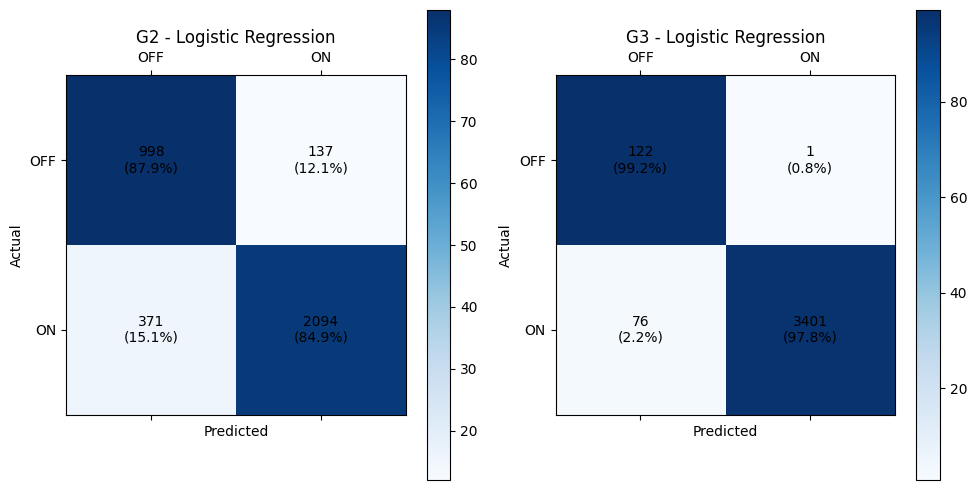

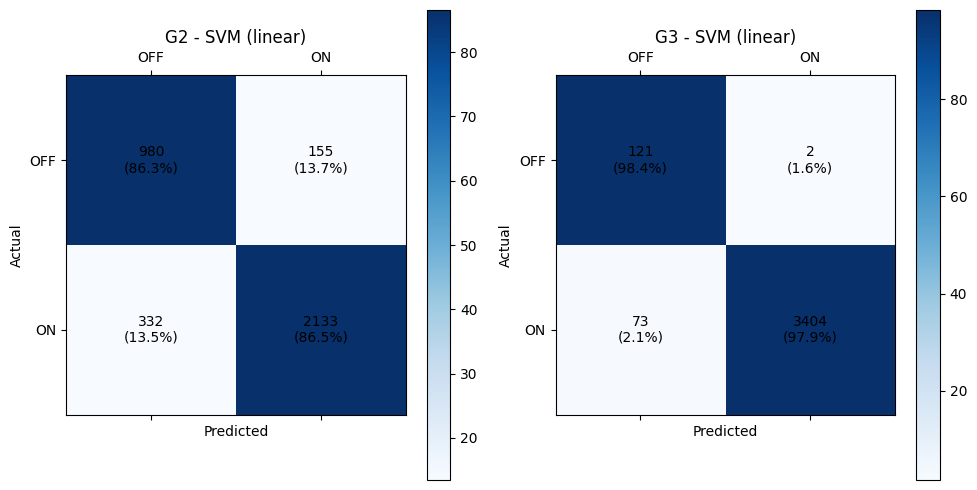

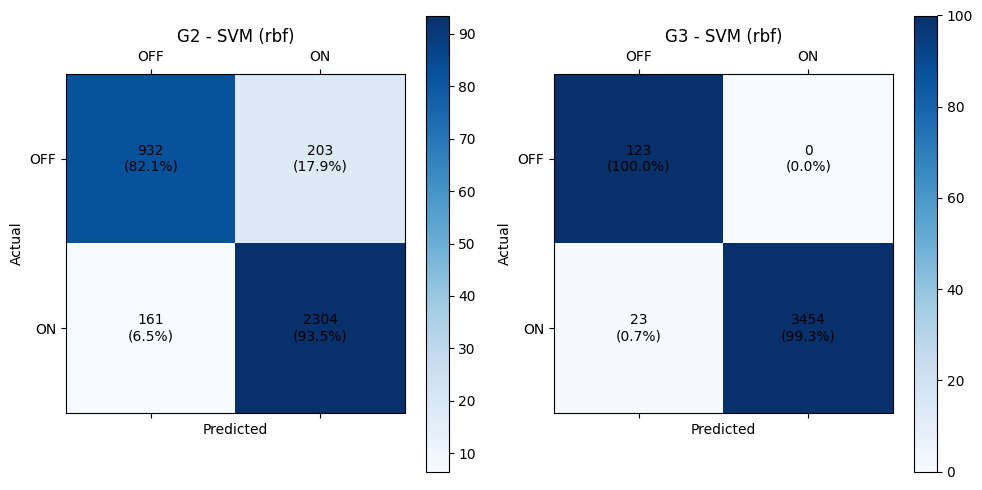

In [43]:
# Plot Confusion Matrices
plot_confusion_matrices(logistic_models, units_to_classify, "Logistic Regression", X_test, y_test)
plot_confusion_matrices(svm_models, units_to_classify, "SVM", X_test, y_test, kernels=kernels)